In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
import os
import glob
import csv

In [2]:
#Path to load data and save results
data_folder = "Data/"  # UPDATE THIS
output_csv = os.path.join(data_folder, "peak_fits_summary.csv")
file_list = sorted(glob.glob(os.path.join(data_folder, "*.dat")))


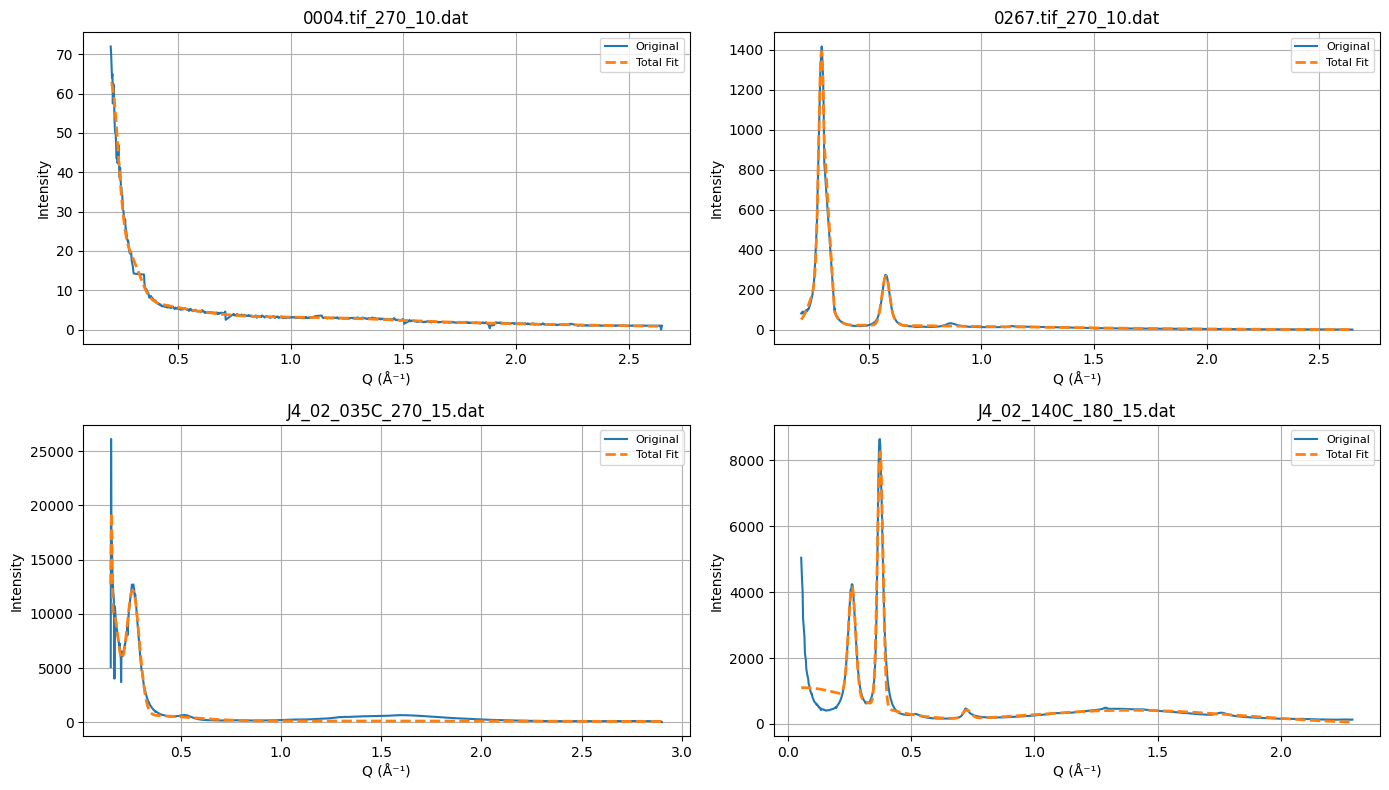


✅ Results saved to: Data/peak_fits_summary.csv


In [ ]:


def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def gaussian_sum(x, *params):
    n = len(params) // 3
    total = np.zeros_like(x)
    for i in range(n):
        A = params[3*i]
        mu = params[3*i + 1]
        sigma = params[3*i + 2]
        total += gaussian(x, A, mu, sigma)
    return total

def fit_gaussian_peak_from_dat(file_path, max_peaks=5):
    data = np.loadtxt(file_path)
    q = data[:, 0]              # Q (Å⁻¹)
    intensity = data[:, 1]      # Intensity

    smoothed = gaussian_filter1d(intensity, sigma=2)
    peaks, properties = find_peaks(smoothed, height=np.max(smoothed) * 0.01, distance=1)
    n = min(max_peaks, len(peaks))

    if n == 0:
        print(f"❌ No peaks detected in {os.path.basename(file_path)}")
        return None

    initial_guess = []
    bounds_lower = []
    bounds_upper = []
    for i in range(n):
        peak_idx = peaks[i]
        A = intensity[peak_idx]
        mu = q[peak_idx]
        sigma = 0.01
        initial_guess += [A, mu, sigma]
        bounds_lower += [0.0, q[0], 0.001]
        bounds_upper += [np.inf, q[-1], (q[-1] - q[0]) / 2]

    try:
        popt, _ = curve_fit(gaussian_sum, q, intensity, p0=initial_guess,
                            bounds=(bounds_lower, bounds_upper), maxfev=100000)
    except RuntimeError:
        print(f"⚠️ Fit failed for {os.path.basename(file_path)}")
        return None

    results = []
    for i in range(n):
        A = popt[3*i]
        mu = popt[3*i + 1]
        sigma = popt[3*i + 2]
        fwhm = 2.3548 * sigma
        results.append((os.path.basename(file_path), i + 1, mu, A, fwhm))

    return q, intensity, gaussian_sum(q, *popt), popt, results

# === Main script ===


# Prepare CSV file
with open(output_csv, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["File", "Peak#", "Q (Å⁻¹)", "I (Amplitude)", "FWHM (Å⁻¹)"])

    plt.figure(figsize=(14, 8))

    for idx, file_path in enumerate(file_list[:4]):  # Only plot first 4
        result = fit_gaussian_peak_from_dat(file_path)
        if result is None:
            continue

        q_vals, intensity, fit_curve, popt, fit_results = result

        # Write to CSV
        for row in fit_results:
            writer.writerow(row)

        # Plot (Optional)
        plt.subplot(2, 2, idx + 1)
        plt.plot(q_vals, intensity, label="Original", lw=1.5)
        plt.plot(q_vals, fit_curve, label="Total Fit", linestyle="--", lw=2)

        # To view individual peak
        # for i in range(len(popt) // 3):
        #     A = popt[3*i]
        #     mu = popt[3*i + 1]
        #     sigma = popt[3*i + 2]
        #     g = gaussian(q_vals, A, mu, sigma)
        #     plt.plot(q_vals, g, linestyle=":", label=f"Peak {i+1}")

        plt.title(os.path.basename(file_path))
        plt.xlabel("Q (Å⁻¹)")
        plt.ylabel("Intensity")
        plt.legend(fontsize=8)
        plt.grid(True)

    plt.tight_layout()
    plt.show()

print(f"\n✅ Results saved to: {output_csv}")
